# Accessing International Debt Statistics (IDS) through World Bank Data API
## Part 2 - Retrieve, explore, and visualize data
### *Python 3*

Date: 04/15/2020, Updated 05/01/2020

[Data source](https://datacatalog.worldbank.org/dataset/international-debt-statistics)<br>
[Developer Information](https://datahelpdesk.worldbank.org/knowledgebase/topics/125589-developer-information)<br>
[GitHub](https://github.com/worldbank/debt-data/tree/master/api-guide)

This is second part of a two-part series on accessing the International Debt Statistics (IDS) database through the World Bank Data API. In [Part 1](https://worldbank.github.io/debt-data/api-guide/ids-api-guide-python-1.html), we queried the World Bank Data API to retrieve indicator names and location codes. In this guide, we will use that information to explore the **regional trends of long-term external debt stocks** from the IDS database. 

The following code in this guide will show step-by-step how to:

1. Setup up your environment with the needed packages.
2. Input your data specifications, as selected in [Part 1](https://worldbank.github.io/debt-data/api-guide/ids-api-guide-python-1.html).
3. Use the World Bank Data API to return the specified data
4. Explore the data through basic descriptive analysis and create a chart.

## 1. Setup
To start, make sure you have the following packages installed on your machine. If you aren't familiar with how to install a Python package, visit each of the linked packages below for instructions.

- [pandas](https://pandas.pydata.org/): Data analysis
- [numpy](https://www.numpy.org/): Data analysis
- [datetime](https://docs.python.org/3.5/library/datetime.html): Parsing dates
- [wbdata](https://wbdata.readthedocs.io/en/latest/#): World Bank Data API wrapper

Then, open your preferred mode of writing Python. This could be in a [Jupyter notebook](https://jupyter.org/) with or without [JupyterLab](https://jupyterlab.readthedocs.io/en/stable/) or in a code editor or IDE such as [Atom](https://atom.io/), [Visual Studio](https://visualstudio.microsoft.com/), or [PyCharm](https://www.jetbrains.com/pycharm/). 

Next, follow the rest of the steps below to retrieve and visualize the World Bank data.

In [143]:
# Import packages
import datetime
import pandas as pd               
import numpy as np
import wbdata

In [145]:
# Package versions used in most recent code update (for compatibility)
print(f"pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"wbdata version: {wbdata.__version__}")

pandas version: 1.0.3
NumPy version: 1.18.1
wbdata version: 0.2.7


## 2. Data Specifications
You will specify the data you want to explore using the following parameters:
- **Indicator(s)**: The indicator code(s) for the data
- **Location(s)**: The location code(s) for the countries, regions, or income level categories
- **Time**: Years
- **Source**: [The World Bank API source](https://datahelpdesk.worldbank.org/knowledgebase/articles/1886686-advanced-data-api-queries)

#### Indicator(s)
In this guide, we will be looking at "long-term external debt stock" from the IDS database. To find the indicator for the data in which you're interested, you can either explore the [World Bank data catalog](https://datacatalog.worldbank.org/dataset/international-debt-statistics) or use an API query as outlined in [Part 1](https://worldbank.github.io/debt-data/api-guide/ids-api-guide-python-1.html) of this series. You can also view the IDS indicators and codes in their hierarchical order on our [data tables](http://datatopics.worldbank.org/debt/ids/). The Analytical view shows the select indicators from the IDS publication and the Standard view shows all available indicators.

In [10]:
# Select the indicator
indicatorSelection = {"DT.DOD.DLXF.CD":"ExternalDebtStock"}

The text that follows the indicator code (in this case, "ExternalDebtStock") should be a description that helps that you correctly identify the indicator. To call more than one indicator, add more indicator names and descriptions to the dictionary.

#### Location(s)
To select a location by country, region, or income level category you will need to know its 2 or 3 letter code. To figure out what this code is, you can either use an API query as outlined in [Part 1](https://worldbank.github.io/debt-data/api-guide/ids-api-guide-python-1.html) of this series or use the convenient [location-codes csv](https://github.com/worldbank/debt-data/blob/master/api-guide/location-codes.csv)* in this repo. 

We will select regional aggregates (these exclude high-income countries):
- ECA: Europe & Central Asia
- SSA: Sub-Saharan Africa
- SAS: South Asia
- LAC: Latin America & the Caribbean
- MNA: Middle East & North Africa
- EAP: East Asia & Pacific


###### *The location-codes csv was created using the API query: http://api.worldbank.org/v2/country?per_page=500&format=json&source=6

In [11]:
# Select the countries or regions
locationSelection = ["ECA","SSA","SAS","LAC","MNA","EAP"]

#### Time
Select the time frame for your data series. The format for the date is year, month, day. We are selecting data from 2009 through 2018.

In [12]:
# Selecting the time frame
timeSelection = (datetime.datetime(2009, 1, 1), datetime.datetime(2018, 12, 31))

#### Source
The World Bank Data API has numerous sources, including one specific to International Debt Statistics. As identified in [Part 1](https://worldbank.github.io/debt-data/api-guide/ids-api-guide-python-1.html), IDS has a source ID of 6.

In [13]:
IDS = wbdata.get_source(source_id=6, display=None)

6	International Debt Statistics


## 3. API Call

In this step, we will retrieve the data using the World Bank Data API call. The package [wbdata](https://wbdata.readthedocs.io/en/stable/) created by Oliver Sherouse, can request information from the World Bank database as a dictionary containing full metadata or as a pandas DataFrame. In this example, we will request the data, with the parameters outlined above, as a pandas DataFrame.

In [115]:
# Making the API call and assigning the resulting DataFrame to "EXD"
EXD = wbdata.get_dataframe(indicatorSelection,
                            country = locationSelection, 
                            data_date = timeSelection, 
                            convert_date = False)

For a quick preview of your freshly retrieved DataFrame, let's print the first 5 lines with the `.head()` method.

In [116]:
# Print the first 5 lines of the DataFrame
EXD.head()

ExternalDebtStock
country                                     date                   
East Asia & Pacific (excluding high income) 2018       1.404732e+12
                                            2017       1.287079e+12
                                            2016       1.170963e+12
                                            2015       1.037230e+12
                                            2014       1.039942e+12

In [117]:
# Make a copy of our DataFrame so we don't need to call the API again if we want to fix something.
EXD_df = EXD.copy()

## 4. Explore the data!
Congratulations! At this point you should have the **long-term external debt stock** for **regions** (excluding high-income economies) from **2009 - 2018** all in a DataFrame called "EXD."

Now we can do the following:
- **Data Cleaning**: Clean up the format to use in a table or populate a visualization
- **Visualization**: Create a simple chart

#### Data Cleaning
As you saw in the preview of the data in section 3, the DataFrame's format needs to be cleaned up. We want to reshape the data. This will get it ready to present in a table or in a visualization.

In [118]:
EXD_df = EXD_df.reset_index()
EXD_df.head()

,country,date,ExternalDebtStock
0,East Asia & Pacific (excluding high income),2018,1.404732e+12
1,East Asia & Pacific (excluding high income),2017,1.287079e+12
2,East Asia & Pacific (excluding high income),2016,1.170963e+12
3,East Asia & Pacific (excluding high income),2015,1.037230e+12
4,East Asia & Pacific (excluding high income),2014,1.039942e+12


In [119]:
EXD_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            60 non-null     object 
 1   date               60 non-null     object 
 2   ExternalDebtStock  60 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.5+ KB


The data for the long-term external debt stock is currently in units. To improve a table's or chart's readability, let's convert the units to billions and round the number to 0 decimal places. 

In [120]:
# Change units to billions and round to 0 decimal places
EXD_df['ExternalDebtStock'] = round(EXD_df['ExternalDebtStock']/1_000_000_000, 0)

In [121]:
EXD_df.head()

,country,date,ExternalDebtStock
0,East Asia & Pacific (excluding high income),2018,1405.0
1,East Asia & Pacific (excluding high income),2017,1287.0
2,East Asia & Pacific (excluding high income),2016,1171.0
3,East Asia & Pacific (excluding high income),2015,1037.0
4,East Asia & Pacific (excluding high income),2014,1040.0


These next two sections of code will clean up the naming of headers and regions. First, it will rename the column headers. Second, it will remove the redundant "(excluding high income)" from the region names. We can instead include that information in the title of the chart.

In [122]:
# Rename column headers
EXD_df.columns=['Region', 'Year', 'ExternalDebtStock']
EXD_df.head()

,Region,Year,ExternalDebtStock
0,East Asia & Pacific (excluding high income),2018,1405.0
1,East Asia & Pacific (excluding high income),2017,1287.0
2,East Asia & Pacific (excluding high income),2016,1171.0
3,East Asia & Pacific (excluding high income),2015,1037.0
4,East Asia & Pacific (excluding high income),2014,1040.0


In [123]:
# Remove "(excluding high income)" from each of the region names
EXD_df["Region"] = EXD_df["Region"].str.replace("\(excluding high income\)","")
EXD_df['Region'].value_counts()

Sub-Saharan Africa             10
South Asia                     10
Middle East & North Africa     10
East Asia & Pacific            10
Europe & Central Asia          10
Latin America & Caribbean      10
Name: Region, dtype: int64

Now our data should be ready to present in a table or visualize in a chart. Let's take a look at the first five lines again so we can compare the cleaned up data to the raw output in section 3.

In [124]:
EXD_df.head()

,Region,Year,ExternalDebtStock
0,East Asia & Pacific,2018,1405.0
1,East Asia & Pacific,2017,1287.0
2,East Asia & Pacific,2016,1171.0
3,East Asia & Pacific,2015,1037.0
4,East Asia & Pacific,2014,1040.0


Make the `Year` column the index and make it a datetime dtype.

In [125]:
EXD_df.index = pd.to_datetime(EXD_df['Year'])
EXD_df = EXD_df.sort_index()
EXD_df.head()

,Region,Year,ExternalDebtStock
Year,,,
2009-01-01,Latin America & Caribbean,2009,747.0
2009-01-01,South Asia,2009,293.0
2009-01-01,Middle East & North Africa,2009,142.0
2009-01-01,Europe & Central Asia,2009,950.0
2009-01-01,East Asia & Pacific,2009,494.0


#### Data Visualization

Let's make a basic line graph with pandas (using Matplotlib as the backend plotting engine). 

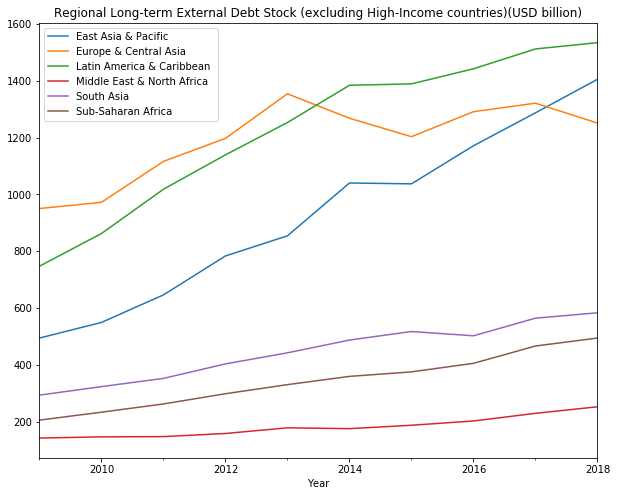

In [139]:
EXD_df.groupby('Region')['ExternalDebtStock'].plot(
    kind='line', 
    legend='Region',
    figsize=(10, 8),
    title="Regional Long-term External Debt Stock (excluding High-Income countries)(USD billion)"
);

# Summary  

You've seen how to retrieve data from the World Bank API and use it to make a visualization! 

We can't wait to see what interesting insights you can uncover with data from World Bank! 🌍